<a href="https://colab.research.google.com/github/SaxMan96/GitHub-Repos-BigData/blob/master/Copy_of_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Constraints

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
import datetime as dt
import time
MAY_14TH = 1557850923.935756

# Defines

In [2]:
def load_data() -> pd.Series:
    csv = pd.read_csv('result_v2.csv', sep=",")
    return csv


def del_nans(nans_perc):
    global csv, nans
    na = csv.isna().sum()
    del_na = na[na >= nans_perc * len(csv)]
    csv = csv.drop(del_na.index.values, axis=1)
    nans = nans_ctr()


def nans_ctr() -> pd.Series:
    return csv.isna().sum()


def unique_ctr() -> pd.Series():
    unique = pd.Series()
    for col in list(csv_org):
        if (csv.columns.contains(col) and (col != 'train')):
            unique.at[col] = len(csv[col].unique())
    return unique


def val_types() -> pd.Series():
    val_type = pd.Series()
    for col in list(csv_org):
        if not csv.columns.contains(col) or col == 'train':
            continue
        if csv[col].dtype == np.float64:
            val_type.at[col] = np.float64
        elif csv[col].dtype == np.int64:
            val_type.at[col] = np.int64
        elif csv[col].dtype == np.int32:
            val_type.at[col] = np.int32
        elif csv[col].dtype == bool:
            val_type.at[col] = bool
        elif csv[col].dtype == object:
            val_type.at[col] = object
        else:
            print(
                f"No common value type found in val_types() - {csv[col].dtype}"
            )
    return val_type


def stat(f):
    nans = nans_ctr()
    unique = unique_ctr()
    val_type = val_types()
    print(f"min: {csv[f].min()}")
    print(f"max: {csv[f].max()}")
    print(f"nans: {nans[f]}")
    print(f"unique: {unique[f]}")
    print(f"val_type: {val_type[f]}")
    print(f"vals per class: {round((len(csv)-nans[f])/unique[f],2)}")


def plot(data, sort=False, log=True, small=False, fontsize=7):
    if small:
        figsize = (8, 4)
    else:
        figsize = (20, 10)
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    if sort:
        ax = df.sort_values(by=0, ascending=False).plot(kind='bar',
                                                        logy=log,
                                                        figsize=figsize,
                                                        legend=False)
    else:
        ax = df.plot(kind='bar', logy=log, figsize=figsize, legend=False)
    plt.xticks(fontsize=fontsize, rotation=90)
    plt.show()


def threshold_factorization(data, *t_list) -> pd.Series():
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df = df.sort_values(by=0, ascending=False)
    t_list = (df.values[0].item() + 1, ) + t_list + (0, )
    out = data.copy()
    for i in tqdm(range(1, len(t_list)), desc="Progress", leave=False):
        idx = df[(df > t_list[i]).values & (df <= t_list[i - 1]).values].index
        for j in tqdm(idx, leave=False):
            out.loc[out == j] = i
    return out


def factorize(data) -> pd.Series():
    series = data.copy()
    labels, _ = pd.factorize(series)
    series = labels[:len(series)]
    return series


def cast(data, lower_t, upper_t) -> pd.Series():
    data = data.sort_values()
    data[data < lower_t] = lower_t
    data[data > upper_t] = upper_t
    return data


def standarize(df) -> pd.Series():
    return df


#     return round((df-df.min())/(df.max()-df.min()),4)


def one_hot_encoding(f):
    global csv
    ohe = ce.OneHotEncoder(cols=[f],
                           handle_unknown='ignore',
                           use_cat_names=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f], axis=1)
    csv = pd.concat([csv, new_features], axis=1)


def binary_encoding(f):
    global csv
    ohe = ce.BinaryEncoder(cols=[f],
                           handle_unknown='ignore',
                           drop_invariant=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f], axis=1)
    csv = pd.concat([csv, new_features], axis=1)


def delete(f):
    global csv
    csv[f] = csv_org[f]
    csv = csv.drop(f, axis=1)

In [3]:
def drop_pushedAt_nans(df):
    """Drops records where pushedAt is NaN"""
    isna = pd.isna(df['pushedAt'])
    isna = isna[isna].index
    return df.drop(isna, axis=0)


def fix_negative_time(df):
    """Fix rows where pushedAt is earlier than createdAt (mostly case for forks)"""

    neg_time = (pd.to_datetime(df['pushedAt']) -
                pd.to_datetime(df['createdAt'])).dt.days < 0
    neg_time = neg_time[neg_time].index
    df.loc[neg_time, 'pushedAt'] = df.loc[neg_time, 'createdAt']
    return df


def create_repoage_column(df):
    """Creates RepoAge column (in days)"""

    df['RepoAge'] = MAY_14TH - pd.to_datetime(
        df['createdAt']).apply(lambda x: x.value / 1000000000)
    df['RepoAge'] = (df['RepoAge'] / 60 / 60 / 24).astype(int)
    return df


def create_repolife_column(df):
    """Creates RepoLife column (in days)"""

    df['RepoLife'] = pd.to_datetime(
        df['pushedAt']).apply(lambda x: x.value / 1000000000) - pd.to_datetime(
            df['createdAt']).apply(lambda x: x.value / 1000000000)
    df['RepoLife'] = (df['RepoLife'] / 60 / 60 / 24).astype(int)
    return df


def create_label_column(df):
    """Creates label column (whether or not there was a push in last 3 months)"""
    df['label'] = (MAY_14TH - pd.to_datetime(
        df['pushedAt']).apply(lambda x: x.value / 1000000000)) / 60 / 60 / 24
    df['label'] = (df['label'] < 90).astype(int)
    return df

# Data Loading

In [4]:
csv = load_data()
csv_org = csv.copy()
nans = nans_ctr()
unique = unique_ctr()
val_type = val_types()
for i in csv.columns:
    print(i)

Unnamed: 0
name
description
createdAt
diskUsage
forkCount
squashMergeAllowed
pushedAt
isArchived
isDisabled
isFork
isLocked
isMirror
isPrivate
url
_uri
_created
_processed
C
Objective-C
Shell
C++
unclosed_issues
assign_
assign_bio
assign_company
stargazer_
stargazer_bio
stargazer_company
milestone
milestone_closed
release_
release_isDraft
release_isPrerelease
contributed-to
contributed-to_bio
contributed-to_company
contributed-to_created
contributed-to_follows
contributed-to_wrote
contributed-to_watches
Ruby
Scheme
TeX
Emacs Lisp
Makefile
Python
Jupyter Notebook
Haskell
TypeScript
JavaScript
HTML
CSS
CMake
GLSL
HLSL
XSLT
Go
Perl
Hy
Rust
Java
Vim script
Assembly
Fortran
Lua
Batchfile
Lex
Yacc
Groff
Roff
Filebench WML
Protocol Buffer
Thrift
R
Gnuplot
M4
Awk
GDB
SourcePawn
Gherkin
XS
Clojure
Prolog
UnrealScript
AMPL
Perl 6
Logos
PowerShell
PHP
Arduino
DTrace
Objective-C++
Swift
Dockerfile
RenderScript
LLVM
Mathematica
MATLAB
Mercury
M
Forth
Cuda
Racket
Scala
PureBasic
Smarty
NSIS
Haxe
D
s

# Data Preprocessing

In [5]:
csv = drop_pushedAt_nans(csv)
csv = fix_negative_time(csv)
# csv = create_repoage_column(csv)
# csv = create_repolife_column(csv)
csv = create_label_column(csv)

In [6]:
languages = [
    "C", "Objective-C", "Shell", "C++", "Ruby", "Scheme", "TeX", "Emacs Lisp",
    "Makefile", "Python", "Jupyter Notebook", "Haskell", "TypeScript",
    "JavaScript", "HTML", "CSS", "CMake", "GLSL", "HLSL", "XSLT", "Go", "Perl",
    "Hy", "Rust", "Java", "Vim script", "Assembly", "Fortran", "Lua",
    "Batchfile", "Lex", "Yacc", "Groff", "Roff", "Filebench WML",
    "Protocol Buffer", "Thrift", "R", "Gnuplot", "M4", "Awk", "GDB",
    "SourcePawn", "Gherkin", "XS", "Clojure", "Prolog", "UnrealScript", "AMPL",
    "Perl 6", "Logos", "PowerShell", "PHP", "Arduino", "DTrace",
    "Objective-C++", "Swift", "Dockerfile", "RenderScript", "LLVM",
    "Mathematica", "MATLAB", "Mercury", "M", "Forth", "Cuda", "Racket",
    "Scala", "PureBasic", "Smarty", "NSIS", "Haxe", "D", "sed", "Kotlin",
    "QMake", "SuperCollider", "Smalltalk", "Julia", "Nim", "CartoCSS",
    "SystemVerilog", "Verilog", "VHDL", "Tcl", "Coq", "Common Lisp", "C#",
    "Processing", "AppleScript", "Limbo", "OCaml", "Groovy", "Scilab", "ASP",
    "Visual Basic", "Pascal", "RobotFramework", "PLSQL", "PLpgSQL", "SQLPL",
    "Cap'n Proto", "Standard ML", "Ragel in Ruby Host", "CoffeeScript", "Ada",
    "Rebol", "nesC", "LilyPond", "ApacheConf", "Vue", "Eagle", "Cool", "Bison",
    "OpenSCAD", "RPC", "ActionScript", "PostScript", "Elm", "YARA", "Slash",
    "ANTLR", "Game Maker Language", "DIGITAL Command Language", "eC", "Elixir",
    "Graphviz (DOT)", "Erlang", "GAP", "Brainfuck", "OpenEdge ABL",
    "POV-Ray SDL", "Mirah", "Terra", "Frege", "Csound Score", "Mako", "Clean",
    "GCC Machine Description", "Io", "Rich Text Format", "Inno Setup",
    "Turing", "Dart", "VCL", "Module Management System"
]

In [7]:
popularLanguages = [
    'Ruby', 'Python', 'Shell', 'HTML', 'JavaScript', 'Makefile', 'C++', 'C',
    'Java', 'CSS'
]
for l in popularLanguages:
    print(round(100 * (1 - nans[l] / len(csv.index))), "% ", l)

8.0 %  Ruby
48.0 %  Python
39.0 %  Shell
25.0 %  HTML
22.0 %  JavaScript
23.0 %  Makefile
27.0 %  C++
28.0 %  C
9.0 %  Java
18.0 %  CSS


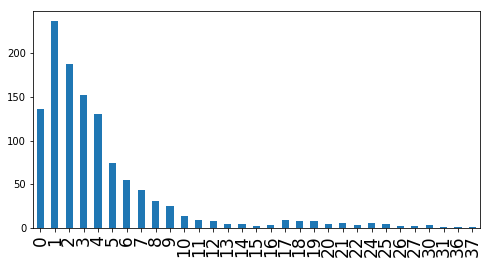

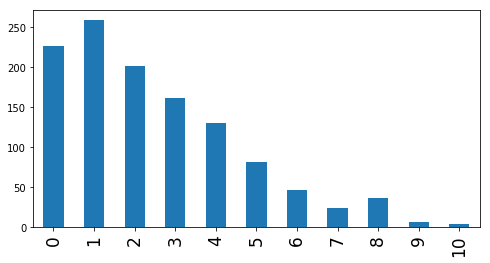

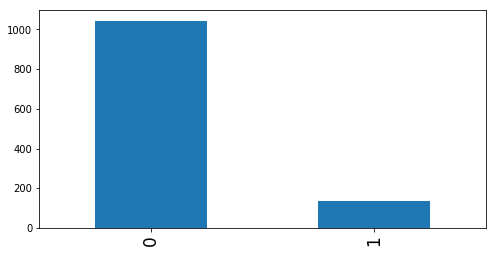

In [8]:
f1 = "languageCounter"
f2 = "popularLanguageCounter"
f3 = "hasLanguage"

csv[languages] = csv_org[languages]
csv[f1] = csv[languages].count(axis=1)
csv[f2] = csv[popularLanguages].count(axis=1)
for l in languages:
    if l in popularLanguages:
        continue
    delete(l)

csv[popularLanguages] = csv[popularLanguages].fillna(0)

# csv[f1] = cast(csv[f1], -100, csv[f1].quantile(0.99))
# csv[f1] = standarize(csv[f1])
plot(csv[f1].sort_values(), sort=False, log=False, fontsize=17, small=True)

# csv[f2] = cast(csv[f2], -100, csv[f2].quantile(0.99))
# csv[f2] = standarize(csv[f2])
plot(csv[f2].sort_values(), sort=False, log=False, fontsize=17, small=True)

csv[f3] = csv[f1] > 0.0
csv[f3] = factorize(csv[f3])
plot(csv[f3].sort_values(), sort=False, log=False, fontsize=17, small=True)

In [9]:
to_delete = ("_created", "_processed", "Unnamed: 0", "name", "isDisabled",
             "isLocked", "isMirror", "isPrivate", "url", "_uri",
             "assign_company", "stargazer_bio", "stargazer_company",
             "release_isDraft", "release_isPrerelease",
              'createdAt', 'pushedAt')
for f in to_delete:
    delete(f)

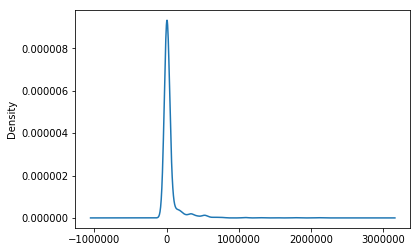

In [10]:
f = "diskUsage"
csv[f] = csv_org[f]
# csv[f] = cast(csv[f], -100, csv[f].quantile(0.95))
# csv[f] = csv[f].apply(lambda x: np.power(x, 1 / 5))
# csv[f] = standarize(csv[f])
csv[f].plot.kde()

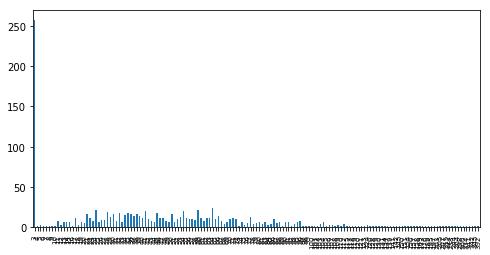

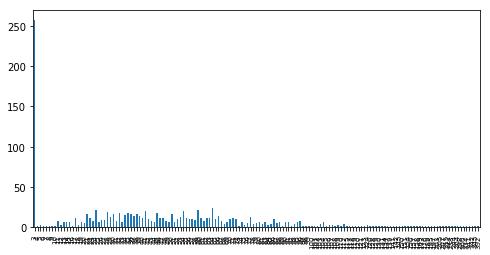

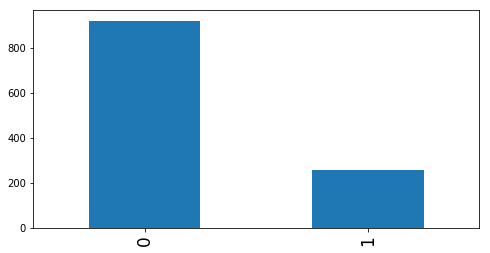

In [11]:
f = "description"
f2 = "description_len"
f3 = "has_description"
csv[f] = csv_org[f]
csv[f2] = csv[f].astype(str).str.len()
csv[f3] = csv[f2] > 3
csv[f3] = factorize(csv[f3])
plot(csv[f2].sort_values(), sort=False, log=False, fontsize=7, small=True)
# csv[f2] = cast(csv[f2], -100, 2 * csv[f2].median())
# csv[f2] = standarize(csv[f2])
plot(csv[f2].sort_values(), sort=False, log=False, fontsize=7, small=True)
plot(csv[f3], log=False, fontsize=17, small=True)
delete(f)

In [12]:
f1 = "squashMergeAllowed"
f2 = "isArchived"
csv[f1] = csv_org[f1]
csv[f2] = csv_org[f2]

csv[f1] = factorize(csv[f1])
csv[f2] = factorize(csv[f2])

# plot(csv_org[f1])
# print(len(csv[csv[f1] == False]))
# print(len(csv[csv[f2] == True]))
# csv.columns

min: 0.0
max: 365.0
nans: 0
unique: 54
val_type: <class 'numpy.float64'>
vals per class: 21.83


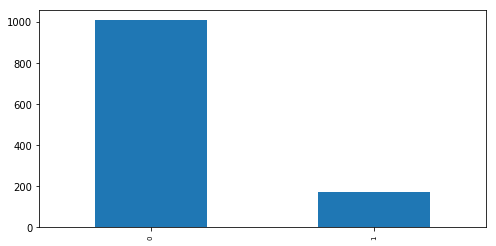

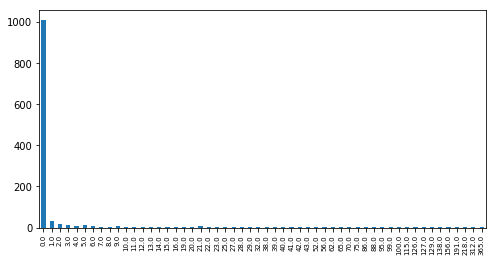

In [13]:
f = "unclosed_issues"
f2 = "has_issue"
stat(f)
csv[f] = csv_org[f]

csv[f2] = csv[f] > 0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False, fontsize=7, small=True)

# csv[f] = cast(csv[f], -100, csv[f].quantile(0.96))
# csv[f] = standarize(csv[f])

plot(csv[f].sort_values(), sort=False, log=False, fontsize=7, small=True)
delete(f)

min: 0.0
max: 9991.0
nans: 0
unique: 146
val_type: <class 'numpy.float64'>
vals per class: 8.08


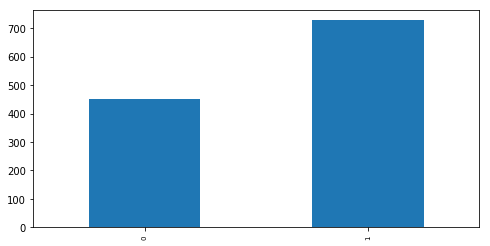

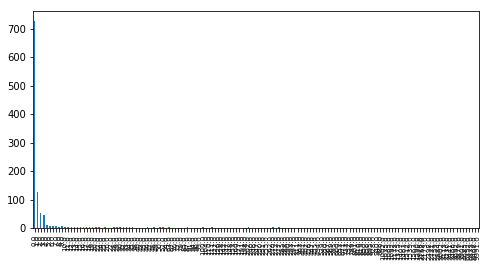

In [14]:
f = "stargazer_"
f2 = "stargazer_non_zero"

stat(f)
csv[f] = csv_org[f]

csv[f2] = csv[f] > 0.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False, fontsize=7, small=True)

# csv[f] = cast(csv[f], -100, csv[f].quantile(0.96))
# csv[f] = standarize(csv[f])

plot(csv[f].sort_values(), sort=False, log=False, fontsize=7, small=True)

min: 0.0
max: 45.0
nans: 0
unique: 9
val_type: <class 'numpy.float64'>
vals per class: 131.0


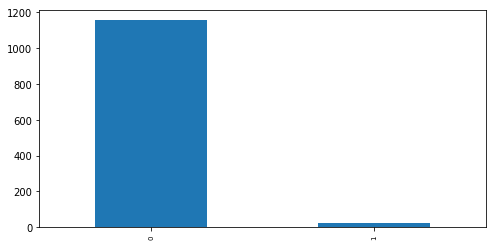

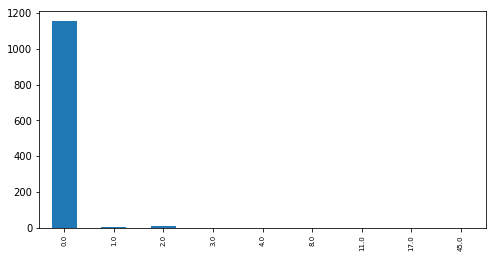

In [15]:
f = "milestone"
f2 = "has_milestone"
stat(f)
csv[f] = csv_org[f]

csv[f2] = csv[f] > 0.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False, fontsize=7, small=True)

# csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
# csv[f] = standarize(csv[f])

plot(csv[f].sort_values(), sort=False, log=False, fontsize=7, small=True)

In [16]:
csv.columns

Index(['diskUsage', 'forkCount', 'squashMergeAllowed', 'isArchived', 'isFork',
       'C', 'Shell', 'C++', 'assign_', 'assign_bio', 'stargazer_', 'milestone',
       'milestone_closed', 'release_', 'contributed-to', 'contributed-to_bio',
       'contributed-to_company', 'contributed-to_created',
       'contributed-to_follows', 'contributed-to_wrote',
       'contributed-to_watches', 'Ruby', 'Makefile', 'Python', 'JavaScript',
       'HTML', 'CSS', 'Java', 'label', 'languageCounter',
       'popularLanguageCounter', 'hasLanguage', 'description_len',
       'has_description', 'has_issue', 'stargazer_non_zero', 'has_milestone'],
      dtype='object')

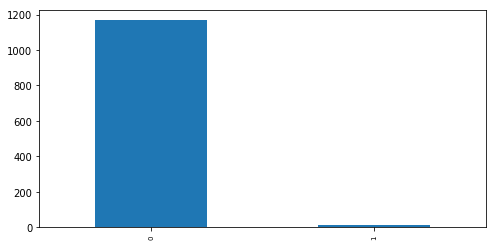

In [17]:
f = "milestone_closed"
f2 = "has_milestone"

csv[f] = csv_org[f]
# stat(f)
csv[f2] = csv[f] > 0.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False, fontsize=7, small=True)
delete(f)

min: 0.0
max: 57.0
nans: 0
unique: 15
val_type: <class 'numpy.float64'>
vals per class: 78.6


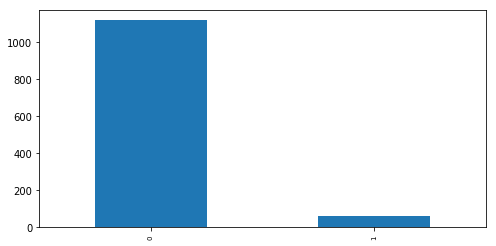

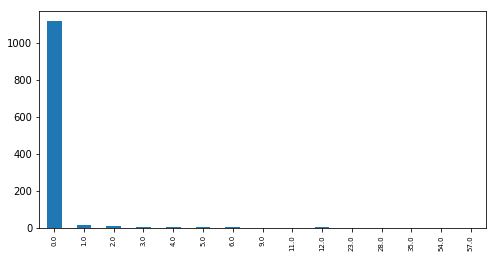

In [18]:
f = "release_"
f2 = "has_release"
stat(f)
csv[f] = csv_org[f]

csv[f2] = csv[f] > 0.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False, fontsize=7, small=True)

# csv[f] = cast(csv[f], -100, csv[f].quantile(0.99))
# csv[f] = standarize(csv[f])

plot(csv[f].sort_values(), sort=False, log=False, fontsize=7, small=True)
delete(f)

501
678


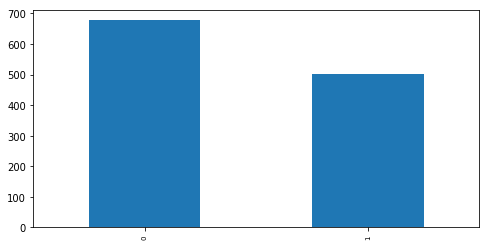

In [19]:
f = "isFork"
print(len(csv[csv[f] == True]))
print(len(csv[csv[f] == False]))
csv[f] = factorize(csv[f])
plot(csv[f].sort_values(), sort=False, log=False, fontsize=7, small=True)

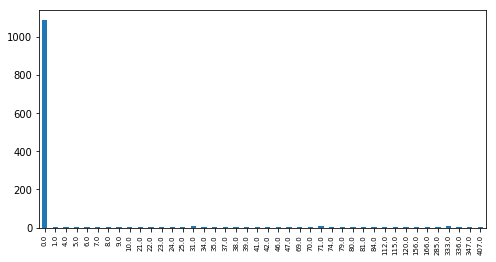

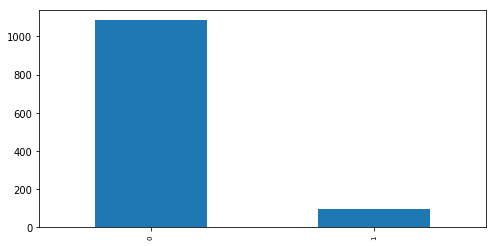

In [20]:
import pandas as pd
new_col = pd.concat([
    csv['contributed-to'], csv['contributed-to_bio'],
    csv['contributed-to_company'], csv['contributed-to_created'],
    csv['contributed-to_follows'], csv['contributed-to_wrote'],
    csv['contributed-to_watches']
],
                    axis=1)
f = 'contributed'
csv[f] = new_col.max(axis=1)

plot(csv[f].sort_values(), sort=False, log=False, fontsize=7, small=True)

csv[f] = csv[f] > 0.0
csv[f] = factorize(csv[f])
plot(csv[f], log=False, fontsize=7, small=True)
to_delete = ('contributed-to', 'contributed-to_bio', 'contributed-to_company',
             'contributed-to_created', 'contributed-to_follows',
             'contributed-to_wrote', 'contributed-to_watches')
for f in to_delete:
    delete(f)

In [21]:
f = 'assign_bio'
print(csv[f].unique())
delete(f)

[0.]


# Save Data

In [22]:
label = csv['label']
csv.drop(labels=['label'], axis=1, inplace=True)
csv.insert(0, 'label', label)
csv.columns

Index(['label', 'diskUsage', 'forkCount', 'squashMergeAllowed', 'isArchived',
       'isFork', 'C', 'Shell', 'C++', 'assign_', 'stargazer_', 'milestone',
       'Ruby', 'Makefile', 'Python', 'JavaScript', 'HTML', 'CSS', 'Java',
       'languageCounter', 'popularLanguageCounter', 'hasLanguage',
       'description_len', 'has_description', 'has_issue', 'stargazer_non_zero',
       'has_milestone', 'has_release', 'contributed'],
      dtype='object')

In [23]:
csv.to_csv("data.csv", sep=',', index=False)

In [24]:
print(len(csv.columns))

29
